In [1]:
import scipy.io

# Load the MAT file
data = scipy.io.loadmat('further_cleaned_data.mat')

In [2]:
# Extract the relevant fields from the data
AE_spindle = data['AE_spindle']
AE_table = data['AE_table']
vib_spindle = data['vib_spindle']
vib_table = data['vib_table']
VB = data['VB']

# Compute row averages for each of the specified fields
features_AE_spindle = AE_spindle.mean(axis=1)
features_AE_table = AE_table.mean(axis=1)
features_vib_spindle = vib_spindle.mean(axis=1)
features_vib_table = vib_table.mean(axis=1)

features_summary = {
    "AE_spindle_mean": features_AE_spindle,
    "AE_table_mean": features_AE_table,
    "vib_spindle_mean": features_vib_spindle,
    "vib_table_mean": features_vib_table,
    "VB": VB.ravel()  
}

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np



# Prepare the feature matrix and target vector
X = np.column_stack((features_AE_spindle, features_AE_table, features_vib_spindle, features_vib_table))
y = features_summary['VB']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create an SVR model within a pipeline that also includes scaling
svr_model = make_pipeline(StandardScaler(), SVR(C=1, epsilon=0.01, gamma=0.1))

# Train the model
svr_model.fit(X_train, y_train)

# Predict on the test data
y_pred = svr_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean squared error:{mse}\nR^2:{r2}')


Mean squared error:0.005377288521788059
R^2:0.7341208064119387


In [33]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__epsilon': [0.01, 0.1, 0.2, 0.5],
    'svr__gamma': [ 0.01, 0.1, 1]
}

# Create a GridSearchCV object with SVR pipeline and parameter grid
grid_search = GridSearchCV(svr_model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Best parameters found
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # Convert from negative MSE to positive MSE

best_params, best_score


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .....svr__C=0.1, svr__epsilon=0.01, svr__gamma=0.01; total time=   0.0s
[CV] END .....svr__C=0.1, svr__epsilon=0.01, svr__gamma=0.01; total time=   0.0s
[CV] END .....svr__C=0.1, svr__epsilon=0.01, svr__gamma=0.01; total time=   0.0s
[CV] END .....svr__C=0.1, svr__epsilon=0.01, svr__gamma=0.01; total time=   0.0s
[CV] END .....svr__C=0.1, svr__epsilon=0.01, svr__gamma=0.01; total time=   0.0s
[CV] END ......svr__C=0.1, svr__epsilon=0.01, svr__gamma=0.1; total time=   0.0s
[CV] END ......svr__C=0.1, svr__epsilon=0.01, svr__gamma=0.1; total time=   0.0s
[CV] END ......svr__C=0.1, svr__epsilon=0.01, svr__gamma=0.1; total time=   0.0s
[CV] END ......svr__C=0.1, svr__epsilon=0.01, svr__gamma=0.1; total time=   0.0s
[CV] END ......svr__C=0.1, svr__epsilon=0.01, svr__gamma=0.1; total time=   0.0s
[CV] END ........svr__C=0.1, svr__epsilon=0.01, svr__gamma=1; total time=   0.0s
[CV] END ........svr__C=0.1, svr__epsilon=0.01,

({'svr__C': 1, 'svr__epsilon': 0.1, 'svr__gamma': 0.1}, 0.009281742325866512)

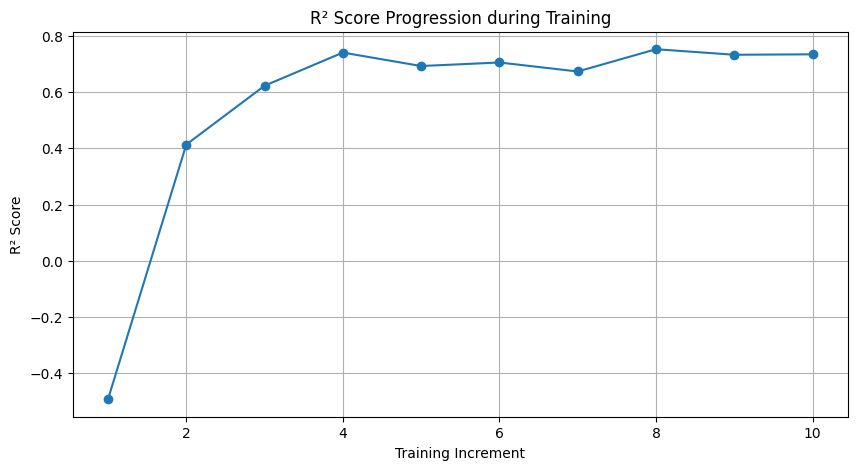

In [34]:
import matplotlib.pyplot as plt

# Initialize the model with the optimized parameters
model = make_pipeline(StandardScaler(), SVR(C=1, epsilon=0.01, gamma=0.1))

# We will train the model incrementally and evaluate on the test set after each increment
r2_scores = []
n_iterations = 10  # You can increase this number based on the size of your dataset and the desired granularity

for i in range(n_iterations):
    # Incrementally train the model on the training set
    model.fit(X_train[:int((i + 1) / n_iterations * len(X_train))], y_train[:int((i + 1) / n_iterations * len(X_train))])
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate and record the R² score
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)

# Plot the R² scores
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_iterations + 1), r2_scores, marker='o')
plt.title('R² Score Progression during Training')
plt.xlabel('Training Increment')
plt.ylabel('R² Score')
plt.grid(True)
plt.show()


In [35]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np

# 创建带有预处理的SVR模型
model = make_pipeline(StandardScaler(), SVR(C=1, epsilon=0.01, gamma=0.1))

# 使用交叉验证来评估模型
scores = cross_val_score(model, X, y, cv=5, scoring='r2')

# 输出交叉验证得到的R²分数
print("R² scores:", scores)
print("Average R² score:", np.mean(scores))



R² scores: [ 0.23189726  0.67105825  0.73846799  0.54270586 -0.00321028]
Average R² score: 0.43618381565862363


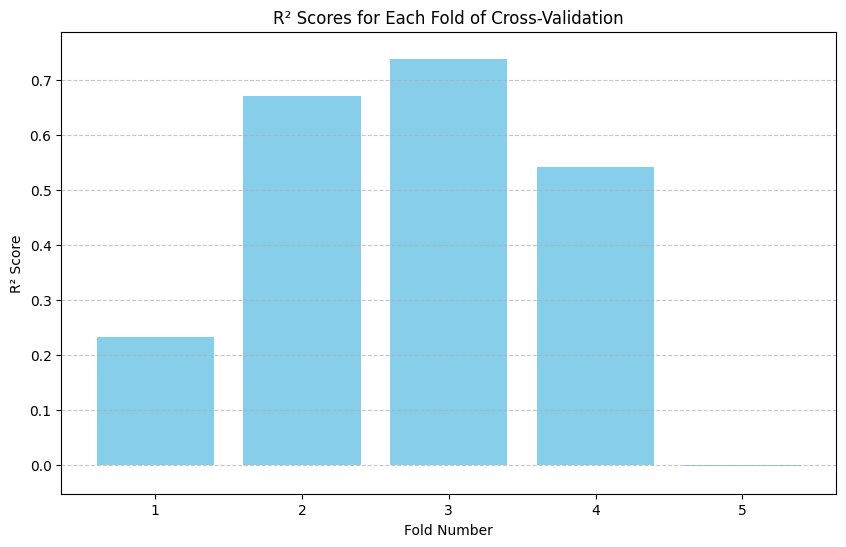

In [36]:
import matplotlib.pyplot as plt



# 创建条形图
plt.figure(figsize=(10, 6))  # 设置图形的大小
plt.bar(range(1, len(scores) + 1), scores, color='skyblue')  # 绘制条形图
plt.xlabel('Fold Number')  # X轴标签
plt.ylabel('R² Score')  # Y轴标签
plt.title('R² Scores for Each Fold of Cross-Validation')  # 图表标题
plt.xticks(range(1, len(scores) + 1))  # 设置X轴的刻度标签
plt.ylim(min(scores)-0.05, max(scores)+0.05)  # 设置Y轴的范围略大于scores的范围，增加可读性
plt.grid(axis='y', linestyle='--', alpha=0.7)  # 添加水平网格线，增强可读性
plt.show()  # 显示图表


In [37]:
data = scipy.io.loadmat('row_119_data.mat')

average_vib_spindle = data['vib_spindle'].mean()
average_vib_table = data['vib_table'].mean()
average_AE_table = data['AE_table'].mean()
average_AE_spindle = data['AE_spindle'].mean()

average_vib_spindle, average_vib_table, average_AE_table, average_AE_spindle

import numpy as np

# 将特征值组合成一个数组
features_array = np.array([[average_vib_spindle, average_vib_table, average_AE_table, average_AE_spindle]])

# 使用之前训练的最优化SVR模型进行预测
# 确保model已经是训练并优化过的SVR模型实例
predicted_VB = svr_model.predict(features_array)

# 输出预测结果
print("Predicted VB value:", predicted_VB[0])
print(f'Actual VB value: {data["VB"]}')



Predicted VB value: 0.3652959490157055
Actual VB value: [[0.24]]
